# Setup

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

## Utils

In [2]:
def read_arrests():
    # Loading Arrests dataset
    arrests_df = pd.read_csv('../data/Pulled/Opioid_Seizures_and_Arrests_CY_2013_-_Current_Quarterly_County_State_Police.csv')

    # removing the index column and removing any duplicates in the initial dataset
    arrests_df.drop('Unnamed: 0', axis=1, inplace=True)
    arrests_df.drop_duplicates(inplace=True)

    keep_columns = ['County Name', 'Year', 'Qtr', 'Drug', 'Incident Count', 'Drug Quantity', 'Arrests']
    arrests_df = arrests_df[keep_columns]
    
    arrests_df = arrests_df.groupby(['County Name', 'Year', 'Qtr', 'Drug']).sum().reset_index()
    arrests_df.rename(columns={'County Name': 'County',
                               'Incident Count': 'Count-seized',
                               'Qtr': 'Quarter'
                               },
                      inplace=True)
    
    arrests_df = arrests_df.pivot(index=['County', 'Year', 'Quarter'],
                                  columns='Drug',
                                  values=['Count-seized', 'Arrests', 'Drug Quantity']).reset_index()

    arrests_df.columns = arrests_df.columns.map('-'.join).str.strip('-')
    arrests_df.columns = arrests_df.columns = [s.replace('-', ' - ') for s in arrests_df.columns]

    arrests_df = arrests_df.fillna(0)
    
    return arrests_df


def create_timeseries_data(county = "Philadelphia"):
    incidents_df = pd.read_csv('../data/Aggregated/incidents.csv')
    
    incidents_df = incidents_df[incidents_df['Incident County Name'] == county]
    
    incidents_df['Quarter'] = incidents_df['Incident Date'].apply(lambda x: "Q" + str(pd.Timestamp(datetime.strptime(x,"%m/%d/%Y")).quarter))
    
    incidents_df["Fentanyl"] = incidents_df["All Drugs"].apply(lambda x: 1 if "FENTANYL" in x else 0)
    
    incidents_df["Heroin"] = incidents_df["All Drugs"].apply(lambda x: 1 if "HEROIN" in x else 0)
    
    incidents_df["Year"] = incidents_df["Incident Date"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y").year)
    
    incidents_df['Count'] = 1

    return incidents_df
    

# Read Datasets

In [3]:
test = read_arrests()
time_series_df = create_timeseries_data()

## Data preprocessing

In [4]:
ls = ["Incident County Name",
      "Naloxone Administered",
      "All Drugs",
      "Quarter",
      "Year",
      "Fentanyl",
      "Heroin",
      "Count"]

time_series_df = time_series_df[ls]
time_series_df = time_series_df.groupby(['Incident County Name',
                                         'Year',
                                         'Quarter']).sum().reset_index()
time_series_df.rename(columns={'Incident County Name': 'County'}, inplace=True)

# Sanity Check
test[(test['County'] == 'Philadelphia')]

,County,Year,Quarter,Count - seized - Fentanyl,Count - seized - Heroin,Count - seized - Opium,Arrests - Fentanyl,Arrests - Heroin,Arrests - Opium,Drug Quantity - Fentanyl,Drug Quantity - Heroin,Drug Quantity - Opium
1670,Philadelphia,2013,Q1,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.217000,0.000000
1671,Philadelphia,2013,Q2,0.0,5.0,1.0,0.0,12.0,1.0,0.000000,0.001360,0.001000
1672,Philadelphia,2013,Q3,0.0,4.0,0.0,0.0,2.0,0.0,0.000000,0.020808,0.000000
1673,Philadelphia,2013,Q4,0.0,4.0,0.0,0.0,2.0,0.0,0.000000,0.050900,0.000000
1674,Philadelphia,2014,Q1,0.0,11.0,0.0,0.0,4.0,0.0,0.000000,1.413741,0.000000
1675,Philadelphia,2014,Q2,0.0,13.0,0.0,0.0,19.0,0.0,0.000000,1.428101,0.000000
1676,Philadelphia,2014,Q3,0.0,16.0,0.0,0.0,14.0,0.0,0.000000,0.215970,0.000000
1677,Philadelphia,2014,Q4,0.0,17.0,0.0,0.0,15.0,0.0,0.000000,0.184910,0.000000
1678,Philadelphia,2015,Q1,0.0,14.0,1.0,0.0,11.0,1.0,0.000000,0.441190,0.000050
1679,Philadelphia,2015,Q2,0.0,13.0,0.0,0.0,12.0,0.0,0.000000,2.208425,0.000000


In [7]:
## Merge arrests and incidents dfs
joined_df = time_series_df.merge(test,
                                 right_on=['County', 'Year', 'Quarter'],
                                 left_on=['County', 'Year', 'Quarter'])

joined_df['Quarter']= joined_df['Quarter'].astype('category')
joined_df = joined_df

# Sanity Check
joined_df

,County,Year,Quarter,Naloxone Administered,Fentanyl,Heroin,Count,Count - seized - Fentanyl,Count - seized - Heroin,Count - seized - Opium,Arrests - Fentanyl,Arrests - Heroin,Arrests - Opium,Drug Quantity - Fentanyl,Drug Quantity - Heroin,Drug Quantity - Opium
0,Philadelphia,2018,Q1,8,0,7,9,3.0,23.0,0.0,1.0,24.0,0.0,0.008200,4.943441,0.000000
1,Philadelphia,2018,Q2,9,1,9,9,4.0,38.0,1.0,4.0,29.0,1.0,6.345000,0.614977,0.000001
2,Philadelphia,2018,Q3,19,6,15,20,2.0,43.0,0.0,4.0,44.0,0.0,3.002300,5.531291,0.000000
3,Philadelphia,2018,Q4,3,0,3,3,2.0,26.0,0.0,1.0,32.0,0.0,5.001000,0.966192,0.000000
4,Philadelphia,2019,Q1,9,3,10,10,5.0,51.0,0.0,5.0,60.0,0.0,0.743920,1.655758,0.000000
5,Philadelphia,2019,Q2,9,2,9,10,17.0,73.0,0.0,15.0,62.0,0.0,6.256950,11.601448,0.000000
6,Philadelphia,2019,Q3,15,6,16,16,10.0,53.0,0.0,8.0,48.0,0.0,4.229280,7.774910,0.000000
7,Philadelphia,2019,Q4,3,1,3,4,12.0,47.0,0.0,3.0,56.0,0.0,2.059950,0.193859,0.000000
8,Philadelphia,2020,Q1,3,2,3,4,25.0,31.0,0.0,7.0,28.0,0.0,4.658360,0.526530,0.000000
9,Philadelphia,2020,Q2,9,3,8,9,8.0,13.0,0.0,5.0,8.0,0.0,2.380360,0.359480,0.000000


In [8]:
## Opium is mostly 0, so we can remove those features
joined_df = joined_df[[i for i in joined_df.columns if "Opium" not in i]]
joined_df.columns

Index(['County', 'Year', 'Quarter', 'Naloxone Administered', 'Fentanyl',
       'Heroin', 'Count', 'Count - seized - Fentanyl',
       'Count - seized - Heroin', 'Arrests - Fentanyl', 'Arrests - Heroin',
       'Drug Quantity - Fentanyl', 'Drug Quantity - Heroin'],
      dtype='object')

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Finalize features and target dfs
features_ls = [i for i in joined_df.columns if i not in ("County", "Year")]
x = joined_df[features_ls]
y = joined_df["Count"]

# Split dataset with 25% test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 0)

# Random Forest regressor
rfr_pipe = Pipeline(steps=[
                 ('ohe', OneHotEncoder(sparse = False, handle_unknown='ignore')),
                 ('scaler', StandardScaler()),
                 # ('regressor', LinearRegression())
                 ('regressor', RandomForestRegressor(max_depth = 10,
                                                     random_state = 0,
                                                     criterion = "friedman_mse",
                                                     n_estimators = 88,
                                                     max_features = None))
                 ])


# Best so far, Gradient boosting regressor
pipe = Pipeline(steps=[
                 ('ohe', OneHotEncoder(sparse = False, handle_unknown='ignore')),
                 ('scaler', StandardScaler()),
                 # ('regressor', LinearRegression())
                 ('regressor', GradientBoostingRegressor(learning_rate = 0.2,
                                                         loss = "absolute_error",
                                                         n_estimators = 65,
                                                         random_state = 1,
                                                         max_features = "auto",
                                                         max_leaf_nodes = 2
                                                        ))
                 ])



In [40]:
pipe.fit(x_train, y_train)

print(pipe.score(x_test, y_test))

-2.996605314806578


In [41]:
x_test

,Quarter,Naloxone Administered,Fentanyl,Heroin,Count,Count - seized - Fentanyl,Count - seized - Heroin,Arrests - Fentanyl,Arrests - Heroin,Drug Quantity - Fentanyl,Drug Quantity - Heroin
8,Q1,3,2,3,4,25.0,31.0,7.0,28.0,4.658360,0.526530
13,Q2,9,3,8,10,10.0,8.0,10.0,9.0,0.227490,0.026870
20,Q1,7,1,14,15,1.0,1.0,0.0,1.0,0.001000,0.000400
1,Q2,9,1,9,9,4.0,38.0,4.0,29.0,6.345000,0.614977
11,Q4,2,0,4,4,18.0,27.0,6.0,21.0,1.499270,46.374449
10,Q3,7,4,10,11,20.0,25.0,10.0,19.0,3.182498,3.663880


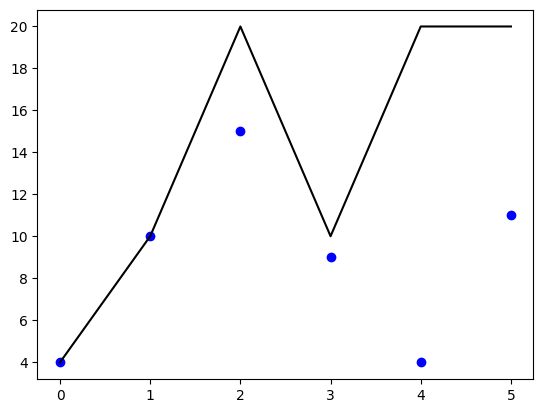

In [42]:
import matplotlib.pyplot as plt

y_pred = pipe.predict(x_test)


plt.scatter([i for i,_ in enumerate(y_pred)], y_test, color ='b')

plt.plot([i for i,_ in enumerate(y_pred)], pd.Series(y_pred), color ='k')

plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pd.Series(y_pred))

60.50416379359959